# Exponentiated Gradient

The ExponentiatedGradient algorithm in Fairlearn is used to produce models that satisfy fairness constraints without needing access to sensitive features at deployment time. This algorithm creates a sequence of re-weighted datasets and retrains the wrapped classifier on each of these datasets. To instantiate an ExponentiatedGradient model, we need to pass in a base estimator and fairness constraints. The fairness constraints are typically specified by providing an upper bound on the difference (or the ratio) between the largest and the smallest value of some statistic (like a false positive rate) across all groups. This bound is often referred to as epsilon.

## Parity constraints and Disparity metrics, group metrics

https://fairlearn.org/v0.13/user_guide/fairness_in_machine_learning.html#parity-constraints



## Example with adult dataset

No matplotlib.Axes object was provided to draw on, so we create a new one


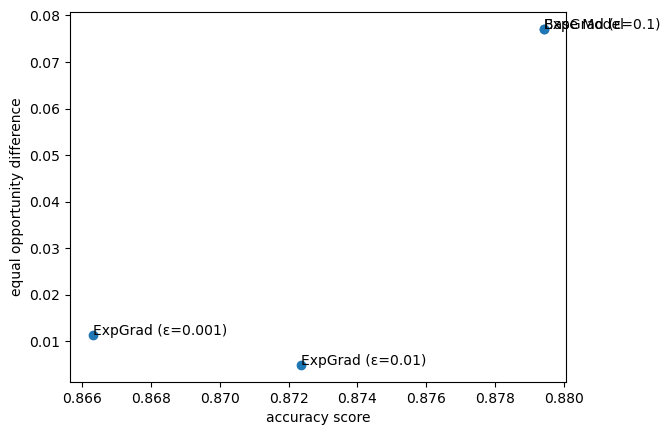

<Axes: xlabel='accuracy score', ylabel='equal opportunity difference'>

In [1]:
from fairlearn.datasets import fetch_adult
from fairlearn.metrics import plot_model_comparison, equal_opportunity_difference
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Fetch and preprocess the data
X, y = fetch_adult(return_X_y=True, as_frame=True)
A = X["sex"]
# Identify features
categorical_features = X.select_dtypes(include='category').columns.tolist()
numeric_features = X.select_dtypes(include='number').columns.tolist()
# Create preprocessor for X
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)])
# Transform y to numerical values
le = LabelEncoder()
y = le.fit_transform(y)
# Create a pipeline with the preprocessor and estimator
estimator = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))])
# Split the data
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=42)
# Train and evaluate the base model
_ = estimator.fit(X_train, y_train)
y_pred_base = estimator.predict(X_test)
# Create a list of ExponentiatedGradient models with different epsilons
epsilons = [0.001, 0.01, 0.1]
exp_grad_models = {}
for eps in epsilons:
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        constraints=EqualizedOdds(difference_bound=eps),
        sample_weight_name="classifier__sample_weight")
    _ = exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    exp_grad_models[f"ExpGrad (ε={eps})"] = exp_grad_est.predict(X_test)
# Add the base model predictions
exp_grad_models["Base Model"] = y_pred_base
# Plot the comparison
plot_model_comparison(
    x_axis_metric=accuracy_score,
    y_axis_metric=equal_opportunity_difference,
    y_true=y_test,
    y_preds=exp_grad_models,
    sensitive_features=A_test,
    show_plot=True,
    point_labels =True)

## Example with COMPAS dataset

Data preprocessing

In [2]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/javism/seminariofate2025/main/data/propublica_recidivism_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/javism/seminariofate2025/main/data/propublica_recidivism_test.csv')

df['race_label'] = 'black'
df.loc[df['race'] == 0, 'race_label'] = 'white'
df_test['race_label'] = 'black'
df_test.loc[df_test['race'] == 0, 'race_label'] = 'white'

# Remove some variables, standarize and binarize label
race_label = df['race_label']
race_label_t = df_test['race_label']
df.drop(['c_charge_desc','decile_score','score_text','race_label'], axis=1, inplace=True)
df_test.drop(['c_charge_desc','decile_score','score_text','race_label'], axis=1, inplace=True)

X = df.drop(['y'], axis=1)
feature_names = X.columns
y = df['y']

#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
#X_test = df_test.drop(['y'], axis=1)
#y_test = df_test['y']
#X_test = scaler.transform(X_test)

In [3]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from fairlearn.metrics import false_positive_rate
from fairlearn.metrics import false_negative_rate
from fairlearn.metrics import true_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.metrics import count

def performance_metrics(y_test, predictions, race_label_t): 
    # Test for discrimination in predictions
    from fairlearn.metrics import MetricFrame,false_negative_rate,false_positive_rate
    from sklearn.metrics import accuracy_score

    grouped_metric = MetricFrame(metrics=accuracy_score,y_true=y_test,y_pred=predictions, sensitive_features=race_label_t)
    print(f"Overall Accuracy = \t{grouped_metric.overall:.4f}")
    print("Accuracy by groups:")
    for key, value in grouped_metric.by_group.to_dict().items():
        print(f"Acc {key}: \t\t{value:.4f}")

    grouped_metric = MetricFrame(metrics=false_negative_rate,y_true=y_test,y_pred=predictions, sensitive_features=race_label_t)
    print(f"Overall FNR = \t\t{grouped_metric.overall:.4f}")
    print("FNR by groups: ")
    for key, value in grouped_metric.by_group.to_dict().items():
        print(f"FNR {key}: \t\t{value:.4f}")

    grouped_metric = MetricFrame(metrics=false_positive_rate,y_true=y_test,y_pred=predictions, sensitive_features=race_label_t)
    print(f"Overall FPR = \t\t{grouped_metric.overall:.4f}")
    print("FPR by groups: ")
    for key, value in grouped_metric.by_group.to_dict().items():
        print(f"\x1B[1mFPR {key}: \t\t{value:.4f}")
        

def performance_plots(y_test, predictions, race_label_t): 
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'false positive rate': false_positive_rate,
        'false negative rate': false_negative_rate,
        'count': count}
    metric_frame = MetricFrame(metrics=metrics,
                               y_true=y_test,
                               y_pred=predictions,
                               sensitive_features=race_label_t)
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title="LR",
    )
    plt.show()

## EqualizedOdds

No matplotlib.Axes object was provided to draw on, so we create a new one


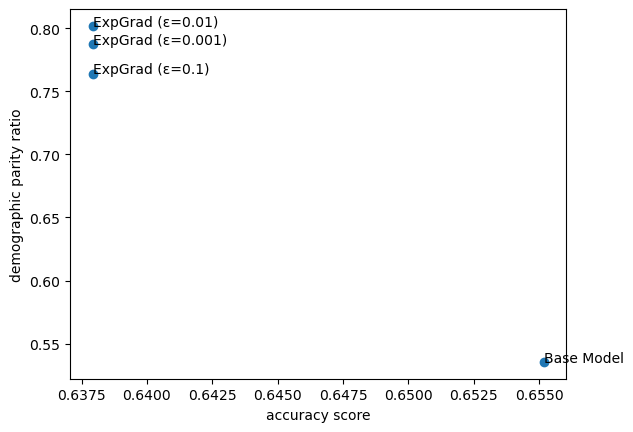

<Axes: xlabel='accuracy score', ylabel='demographic parity ratio'>

In [4]:
from fairlearn.metrics import plot_model_comparison, equal_opportunity_difference, demographic_parity_ratio, false_positive_rate
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

# Fetch and preprocess the data
#X, y = fetch_adult(return_X_y=True, as_frame=True)
A = X["race"]

estimator = Pipeline([
    ('classifier', HistGradientBoostingClassifier(random_state=42))])
# Split the data
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=42)
# Train and evaluate the base model
_ = estimator.fit(X_train, y_train)
y_pred_base = estimator.predict(X_test)
# Create a list of ExponentiatedGradient models with different epsilons
epsilons = [0.001, 0.01, 0.1]
exp_grad_models = {}
for eps in epsilons:
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        constraints=EqualizedOdds(difference_bound=eps),
        sample_weight_name="classifier__sample_weight")
    _ = exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    exp_grad_models[f"ExpGrad (ε={eps})"] = exp_grad_est.predict(X_test)
# Add the base model predictions
exp_grad_models["Base Model"] = y_pred_base

# Plot the comparison
plot_model_comparison(
    x_axis_metric=accuracy_score,
    y_axis_metric=demographic_parity_ratio,
    y_true=y_test,
    y_preds=exp_grad_models,
    sensitive_features=A_test,
    show_plot=True,
    point_labels =True)



Overall Accuracy = 	0.6379
Accuracy by groups:
Acc 0: 		0.5985
Acc 1: 		0.6580
Overall FNR = 		0.4486
FNR by groups: 
FNR 0: 		0.5714
FNR 1: 		0.4000
Overall FPR = 		0.2896
FPR by groups: 
FPR 0: 		0.2959
FPR 1: 		0.2857


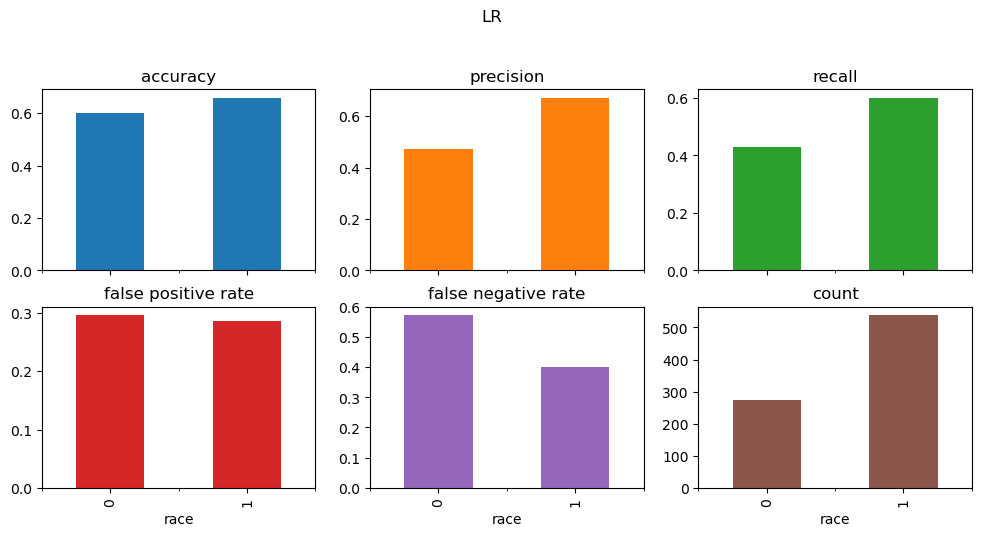

In [5]:
predictions = exp_grad_models['ExpGrad (ε=0.001)']
performance_metrics(y_test, predictions, A_test)
performance_plots(y_test, predictions, A_test)


## ErrorRateParity

No matplotlib.Axes object was provided to draw on, so we create a new one


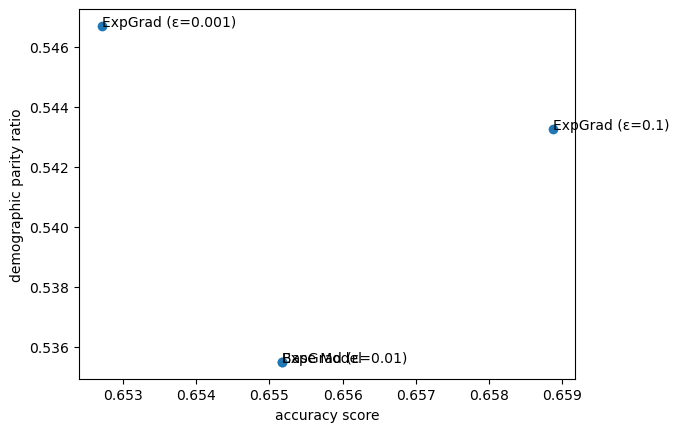

<Axes: xlabel='accuracy score', ylabel='demographic parity ratio'>

In [6]:

from fairlearn.metrics import plot_model_comparison, equal_opportunity_difference, demographic_parity_ratio, false_positive_rate
from fairlearn.reductions import ExponentiatedGradient, ErrorRateParity
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Fetch and preprocess the data
#X, y = fetch_adult(return_X_y=True, as_frame=True)
A = X["race"]

estimator = Pipeline([
    ('classifier', HistGradientBoostingClassifier(random_state=42))])
# Split the data
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=42)
# Train and evaluate the base model
_ = estimator.fit(X_train, y_train)
y_pred_base = estimator.predict(X_test)
# Create a list of ExponentiatedGradient models with different epsilons
epsilons = [0.001, 0.01, 0.1]
exp_grad_models = {}
for eps in epsilons:
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        constraints=ErrorRateParity(difference_bound=eps),
        sample_weight_name="classifier__sample_weight")
    _ = exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    exp_grad_models[f"ExpGrad (ε={eps})"] = exp_grad_est.predict(X_test)
# Add the base model predictions
exp_grad_models["Base Model"] = y_pred_base

# Plot the comparison
plot_model_comparison(
    x_axis_metric=accuracy_score,
    y_axis_metric=demographic_parity_ratio,
    y_true=y_test,
    y_preds=exp_grad_models,
    sensitive_features=A_test,
    show_plot=True,
    point_labels =True)

